# import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# python wrapper for cpp code
from qubo_ising_hmc import Ising

# MDS problem to qubo map (install the other repo)
from qlp.mds.qubo import get_mds_qubo, QUBO_to_Ising
from qlp.mds.graph_tools import get_plot_mpl

The graph is defined as a set of edges. An edge is a tuple of two nodes.

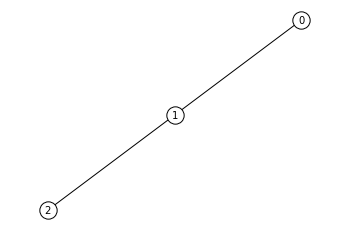

In [2]:
graph = {(0,1), (1,2)}
get_plot_mpl(graph)
plt.show()

Set up the QUBO and ising model. Specify the penalty term

In [3]:
penalty = 2
nodes = set([i for i, _ in graph] + [j for _, j in graph])
n_nodes = len(nodes)

qubo = get_mds_qubo(graph, penalty=penalty, triangularize=True)
J, h, c = QUBO_to_Ising(qubo.todense())

offset = c + penalty * n_nodes

print(J)
print(h)
print(offset)

[[ 0.  2.  1. -1. -1. -2.  0.]
 [ 0.  0.  2. -1. -1. -2. -1.]
 [ 0.  0.  0.  0. -1. -2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
[-2.5 -3.5 -2.5  1.   2.   4.   1. ]
11.5


Add parameters used for ising model

In [4]:
beta = 3.0
md_steps = 10
ergodicity_jumps = -100

In [5]:
print(Ising.__doc__)

Class wraps HMC solver for spin-glass Hamiltonian such that

    H[psi] = psi@J@psi + h@psi + offset

    and the partition function corresponds to

    Z = sum(exp(- beta H[psi]), psi)


    Attributes:
        J: Spin coupling matrix
        h: External magentic field
        offset: Offset of Hamiltonian
        beta: Inverse termperature
        md_steps: Number of molecular dynamics steps
        ergodicity_jumps: Parameter which helps with erogdicity. Defaults to -100

    Note:
        Multiplies with minus one before inserting in CPP class.

    Todo:
        * Test
        * Think about matrix symmerty (Tom uses symmertrization)
    


This is equivalent to your read in and `.initialize()` call.

I have not included the factor of `1/2` you have in your notes when setting up
$$
    K_{sym} = K^T + K
$$

In [6]:
ising = Ising(J, h, offset, beta, md_steps, ergodicity_jumps)

Symmetrisizing J. Ask Tom about the factor of 1/2
('J =', array([[-0., -2., -1.,  1.,  1.,  2., -0.],
       [-2., -0., -2.,  1.,  1.,  2.,  1.],
       [-1., -2., -0., -0.,  1.,  2.,  1.],
       [ 1.,  1., -0., -0., -0., -0., -0.],
       [ 1.,  1.,  1., -0., -0., -2., -0.],
       [ 2.,  2.,  2., -0., -2., -0., -0.],
       [-0.,  1.,  1., -0., -0., -0., -0.]]))
('h_sym =', array([ 2.5,  3.5,  2.5, -1. , -2. , -4. , -1. ]))
('offset =', 11.5)
('C_in =', 6.869786498565076)
('beta =', 3.0)


Thermalize (see `quboIsingHMC.cpp` line 232+)

In [7]:
n_therm = 50000
ising.thermalize(n_therm, md_steps)

Run HMC (see `quboIsingHMC.cpp` line 252+)

This first clears and then populates the 
```
ising.energy
ising.acceptance
ising.configs
```
members

In [8]:
n_trajectories = 500000
save_frequency = 10
ising.run_hmc(n_trajectories, save_frequency)

Compute ensemble averages

In [9]:
e = np.mean(ising.energy)
p = np.mean(ising.acceptance)
psi = np.mean(ising.configs, axis=0) / np.sqrt(ising.beta) - ising.k

ppsi = psi.round(2)
e_gs =  ppsi @ J @ ppsi + h @ ppsi + offset

print("Energy =", e)
print("Acceptance =", p)
print("Ground state =", ppsi)
print(f"Energy from groundstate = {e_gs:1.3f}")

Energy = 0.9284885786052861
Acceptance = 0.9943923121537571
Ground state = [-0.99  1.01 -0.99 -1.   -1.01 -1.01 -1.  ]
Energy from groundstate = 0.977


Note that I played around with a few parameters. As a matter of fact, I get stuck in a 2 node ground state solution if I run with the same parameters as the cpp file. Not sure if something goes wrong.